In [33]:
from io import StringIO
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import glob
from scipy.integrate import cumtrapz
from scipy.fft import fft
import numpy as np
from obspy import Trace
from obspy.signal.trigger import classic_sta_lta, trigger_onset
from sklearn.ensemble import IsolationForest
from scipy import signal
from sklearn.linear_model import LinearRegression




lunar_cat_directory = './space_apps_2024_seismic_detection/data/lunar/training/catalogs/'
lunar_cat_file = lunar_cat_directory + 'apollo12_catalog_GradeA_final.csv'
lunar_cat = pd.read_csv(lunar_cat_file)

# load data directories
lunar_training_data_directory = './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/'
mars_training_data_directory = './space_apps_2024_seismic_detection/data/mars/training/data'

num_files = len(lunar_cat)

In [40]:
def sta_lta(df, expand, sta=1500, lta=5000, thr_on=3, thr_off=1):
    '''
    Dectect and mark trigger on and trigger off times of seismic anomalies using Short Term Average/Long Term Average algorithm

    Parameters:
    - df (pd.DataFrame): DataFrame containing the seismic data.
    - sta (int): Short Time Average window length (in samples).
    - lta (int): Long Time Average window length (in samples).
    - thr_on (float): Trigger on threshold (earthquake detected) in rel time.
    - thr_off (float): Trigger off threshold in rel time.

    Returns:
    - list: A list of tuples containing trigger on and off indices of df.
    '''
    rel_time = np.array(df["time_rel(sec)"])
    samp_rate = 1 / (rel_time[-1] - rel_time[-2])
    offset = int(samp_rate * 240) * expand

    cft = classic_sta_lta(df["velocity(m/s)"], int(sta * samp_rate), int(lta * samp_rate))
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    trig_indices = []
    for i in np.arange(0, len(on_off)):
        trigger = on_off[i]
        trig_indices.append((trigger[0] , trigger[1] ))
        
    return trig_indices

def regression_analysis(df):
    """
    Analyzes amplitude (absolute value of velocity) over time data by performing linear regression,
    returning the correlation (R²), and plotting the amplitude data with the regression line.

    Parameters:
    - df (pd.DataFrame): DataFrame containing possible seismic event data.

    Returns:
    - float: The correlation coefficient (R² value) representing the linear fit.
    """
    # Use the absolute time column instead of the relative time column
    time = pd.to_datetime(df['time_abs(%Y-%m-%dT%H:%M:%S.%f)'])
    time_numeric = (time - time.min()).dt.total_seconds().values.reshape(-1, 1)  # Convert to numeric values for regression

    # Extract velocity and compute amplitude
    velocity = df['velocity(m/s)'].values
    amplitude = np.abs(velocity)

    # Perform linear regression on amplitude vs time
    model = LinearRegression()
    model.fit(time_numeric, amplitude)
    
    # Get the slope and correlation coefficient (R² value)
    slope = model.coef_[0]
    r_squared = model.score(time_numeric, amplitude)
    
    # Generate predicted values for the regression line on amplitude
    amplitude_pred = model.predict(time_numeric)

    # Plotting the original amplitude and regression line
    plt.figure(figsize=(12, 6))
    plt.plot(time, amplitude, label='Amplitude (|Velocity|)', color='blue', alpha=0.5)
    plt.plot(time, amplitude_pred, label='Linear Regression Line', color='red', linestyle='--')
    plt.xlabel('Time (absolute)')
    plt.ylabel('Amplitude (|Velocity| in m/s)')
    plt.title('Amplitude over Time with Linear Regression Line')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Slope: {slope}")
    print(f"R² (correlation coefficient): {r_squared}")
    
    return r_squared

def is_seismic(df):
    """
    Analyzes the possible slices of seismic data by finding trigger events, slicing them, and running linear regression to determine if they represent seismic activity.
    
    Returns:
    - list: A list of indices of true positives
    """
    time_rel = df['time_rel(sec)'].values
    trig_inds = sta_lta(df, 1)
        
    false_positives = []
    true_positives = []
    
    for i, (start_idx, end_idx) in enumerate(trig_inds):
        start_idx = max(0, start_idx)
        end_idx = min(len(df), end_idx)
        
        df_slice = df.iloc[start_idx:end_idx]
        print(f"Analyzing slice {i + 1} (from index {start_idx} to {end_idx})")
        r_squared_value = regression_analysis(df_slice)
        print(f"Slice {i + 1} - Correlation Coefficient (R²): {r_squared_value}\n")
        
        
        if r_squared_value > 0.15:
            true_positives.append(time_rel[start_idx])
        else:
            false_positives.append(time_rel[start_idx])
            
    print(f"false_positives: {false_positives}")
    print(f"true_positives: {true_positives}")
    
    return true_positives



In [44]:
df = pd.read_csv('./space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1970-03-25HR00_evid00003.csv')
is_seismic(df)

false_positives: []
true_positives: []


[]

Analyzing slice 1 (from index 95879 to 108007)


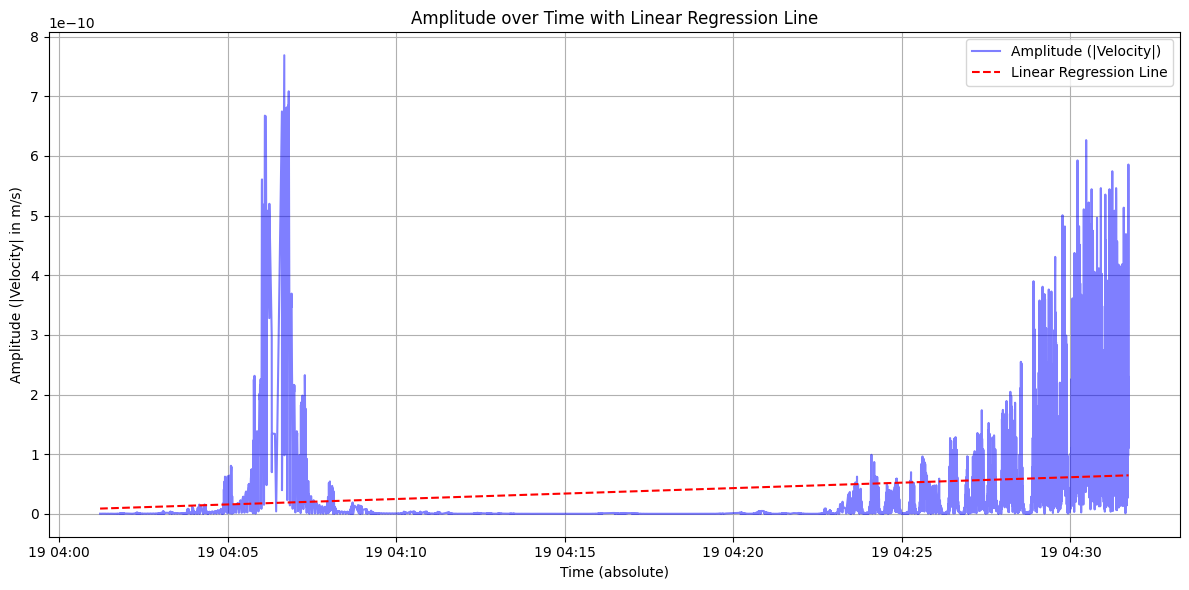

Slope: 3.0448236895552375e-14
R² (correlation coefficient): 0.02861244652204198
Slice 1 - Correlation Coefficient (R²): 0.02861244652204198

Analyzing slice 2 (from index 188311 to 190446)


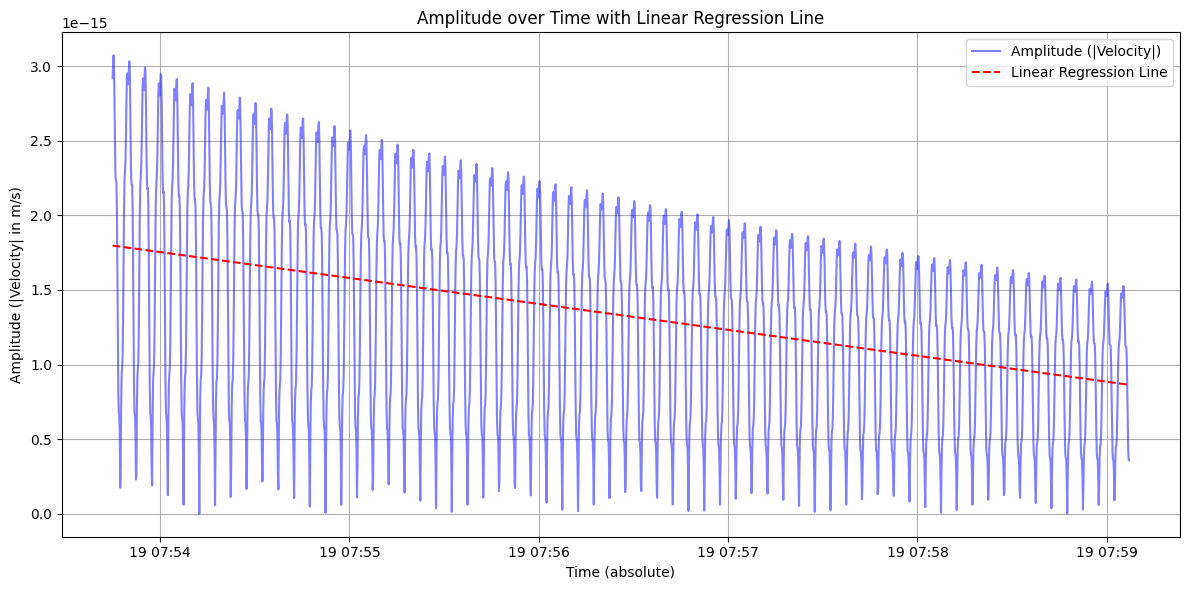

Slope: -2.8951419223220504e-18
R² (correlation coefficient): 0.1416328240557898
Slice 2 - Correlation Coefficient (R²): 0.1416328240557898

Analyzing slice 3 (from index 224242 to 239999)


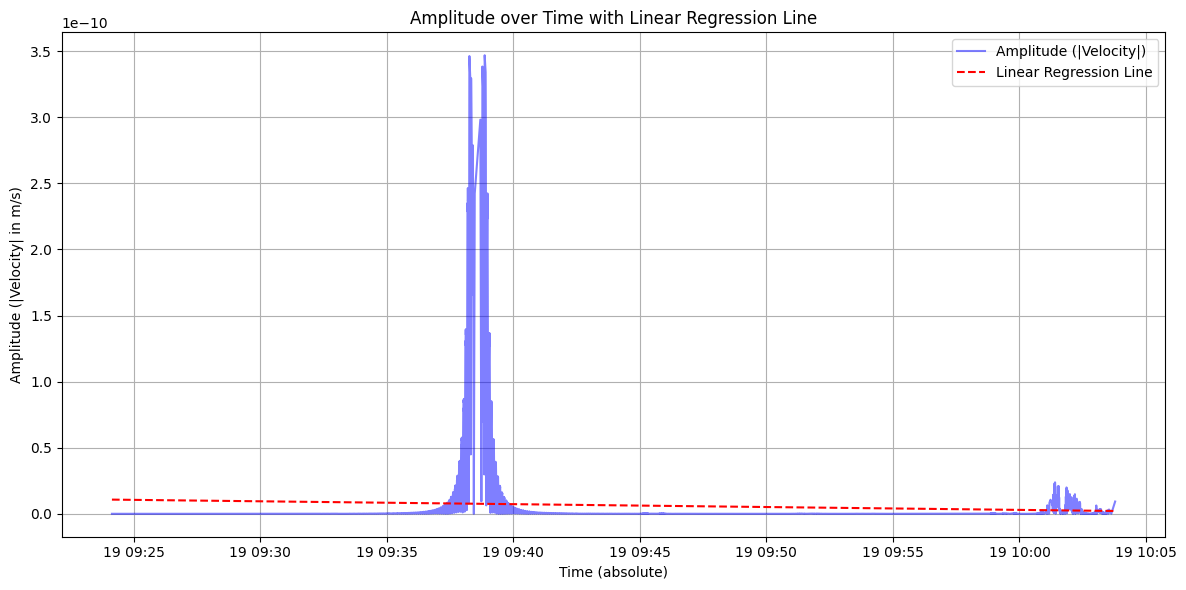

Slope: -3.612911743796874e-15
R² (correlation coefficient): 0.00470168309192176
Slice 3 - Correlation Coefficient (R²): 0.00470168309192176

Analyzing slice 4 (from index 488346 to 504579)


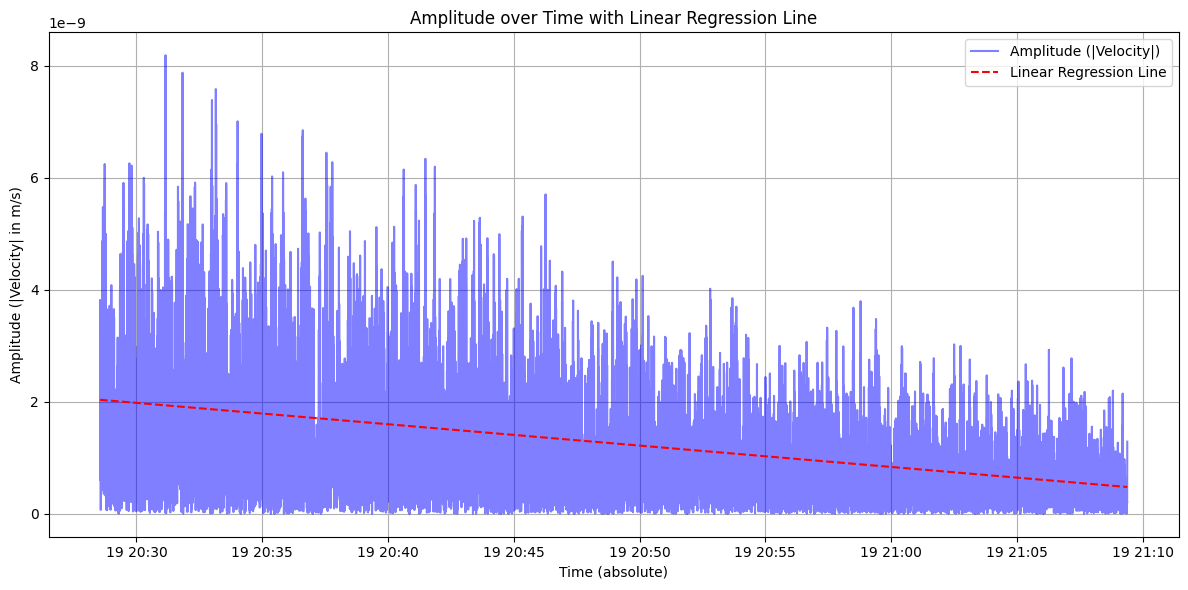

Slope: -6.354195541931268e-13
R² (correlation coefficient): 0.1685747254508544
Slice 4 - Correlation Coefficient (R²): 0.1685747254508544

false_positives: [14472.301886792451, 28424.30188679245, 33847.84905660377]
true_positives: [73712.60377358491]


[73712.60377358491]

In [42]:
lunar_training_file = lunar_training_data_directory + lunar_cat['filename'][0] + '.csv'
l_training_df = pd.read_csv(lunar_training_file)
is_seismic(l_training_df)

Analyzing slice 1 (from index 95879 to 108007)


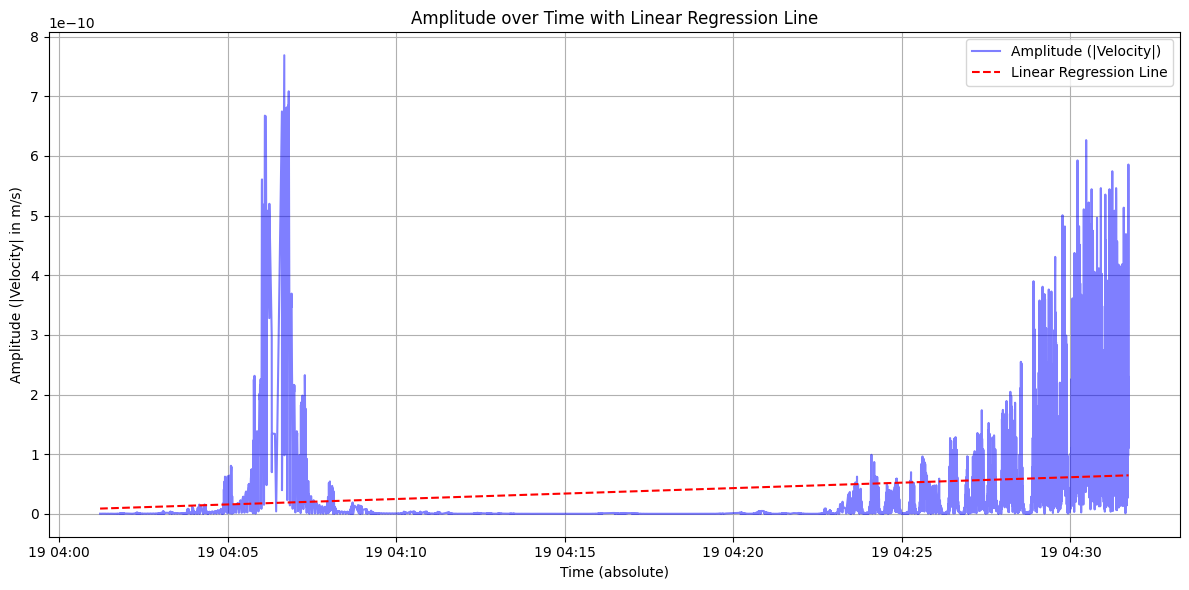

Slope: 3.0448236895552375e-14
R² (correlation coefficient): 0.02861244652204198
Slice 1 - Correlation Coefficient (R²): 0.02861244652204198

Analyzing slice 2 (from index 188311 to 190446)


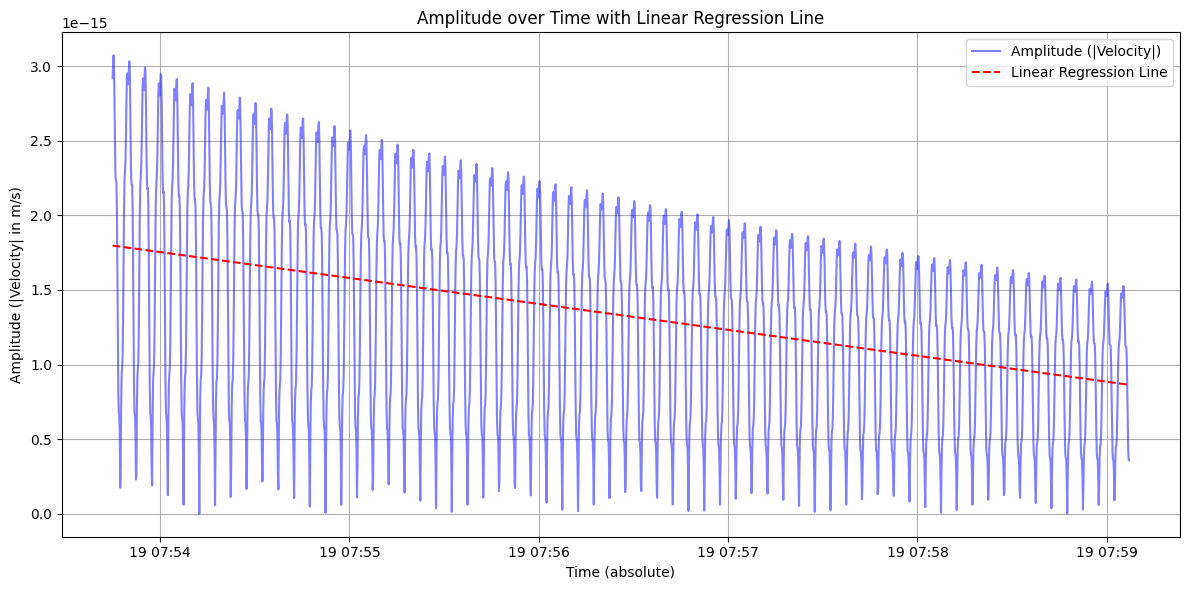

Slope: -2.8951419223220504e-18
R² (correlation coefficient): 0.1416328240557898
Slice 2 - Correlation Coefficient (R²): 0.1416328240557898

Analyzing slice 3 (from index 224242 to 239999)


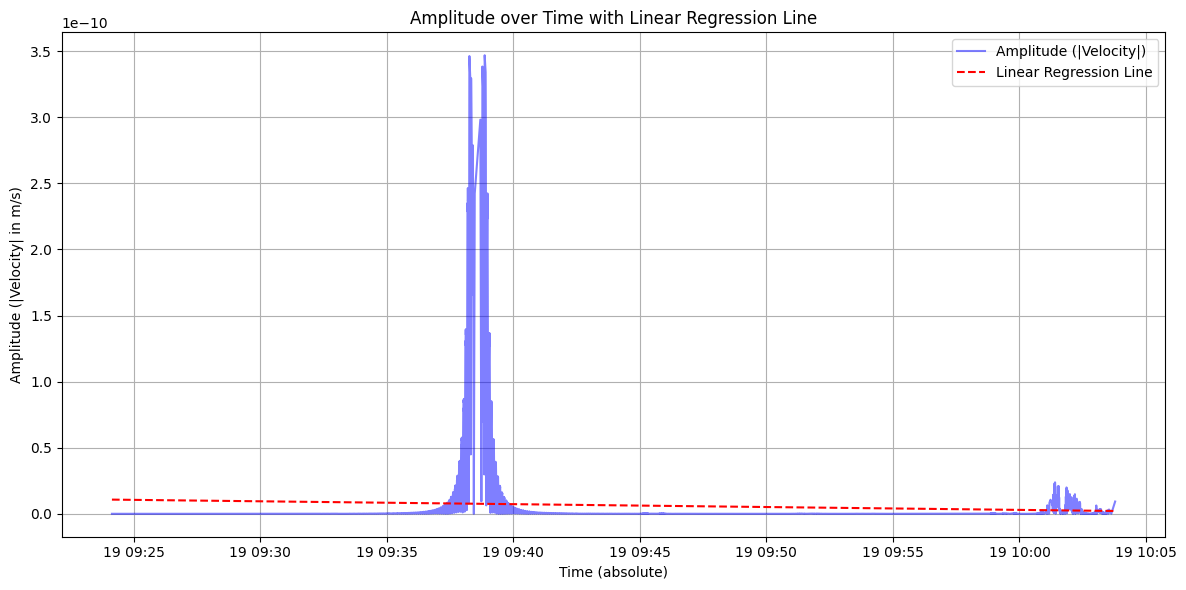

Slope: -3.612911743796874e-15
R² (correlation coefficient): 0.00470168309192176
Slice 3 - Correlation Coefficient (R²): 0.00470168309192176

Analyzing slice 4 (from index 488346 to 504579)


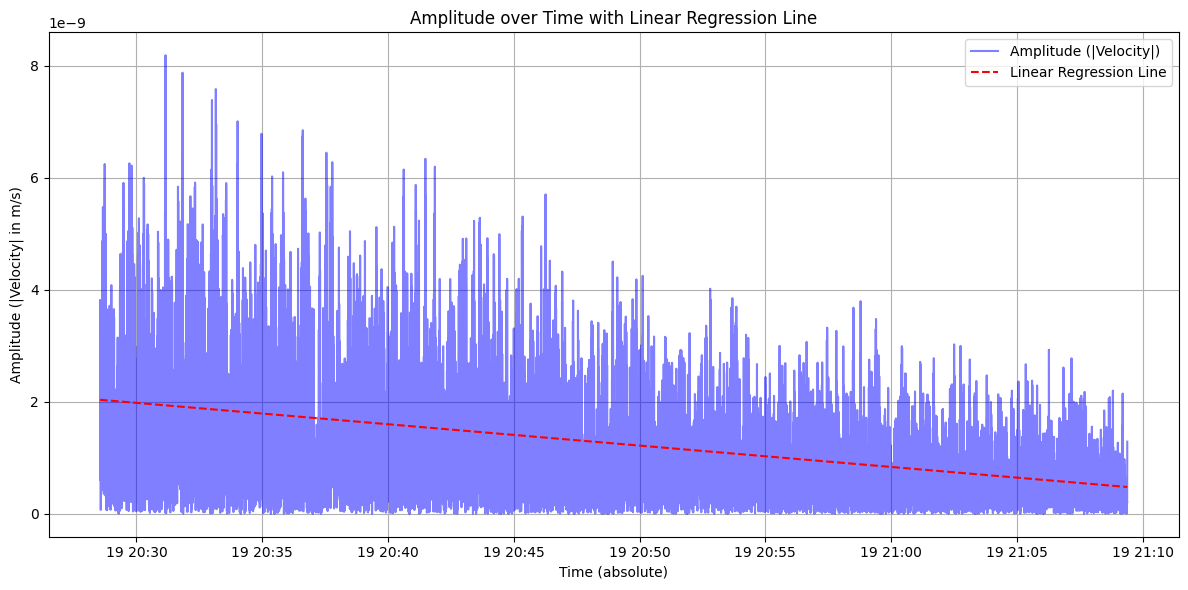

Slope: -6.354195541931268e-13
R² (correlation coefficient): 0.1685747254508544
Slice 4 - Correlation Coefficient (R²): 0.1685747254508544

false_positives: [14472.301886792451, 28424.30188679245, 33847.84905660377, 73712.60377358491]
true_positives: []
false_positives: []
true_positives: []
Analyzing slice 1 (from index 168598 to 198340)


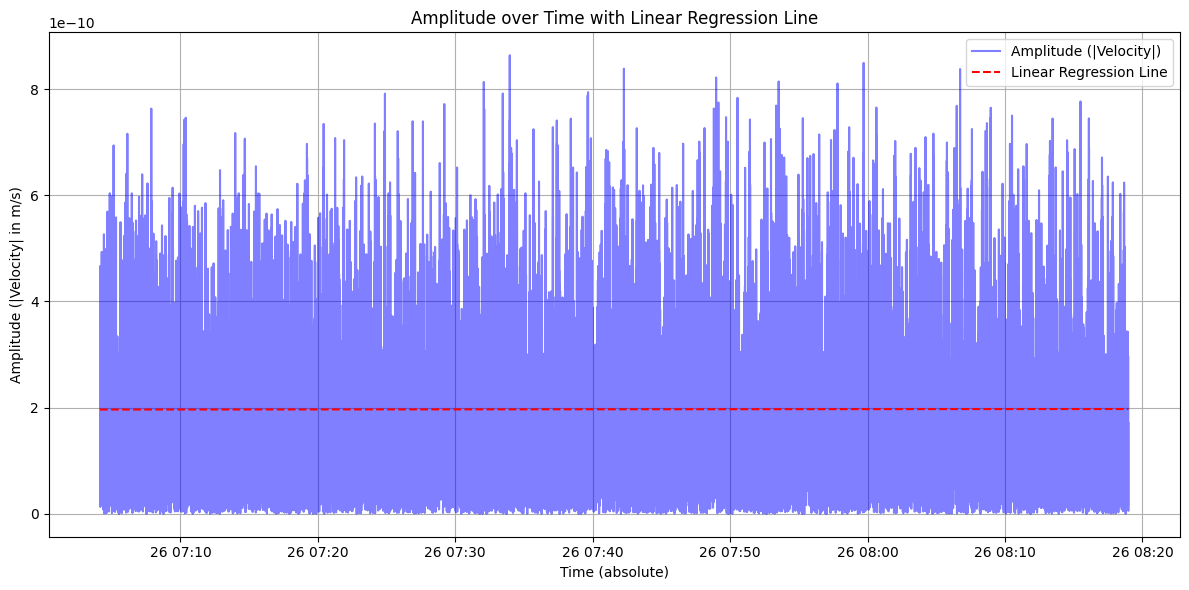

Slope: 2.2263739969184877e-16
R² (correlation coefficient): 4.045538762653678e-06
Slice 1 - Correlation Coefficient (R²): 4.045538762653678e-06

Analyzing slice 2 (from index 488827 to 501889)


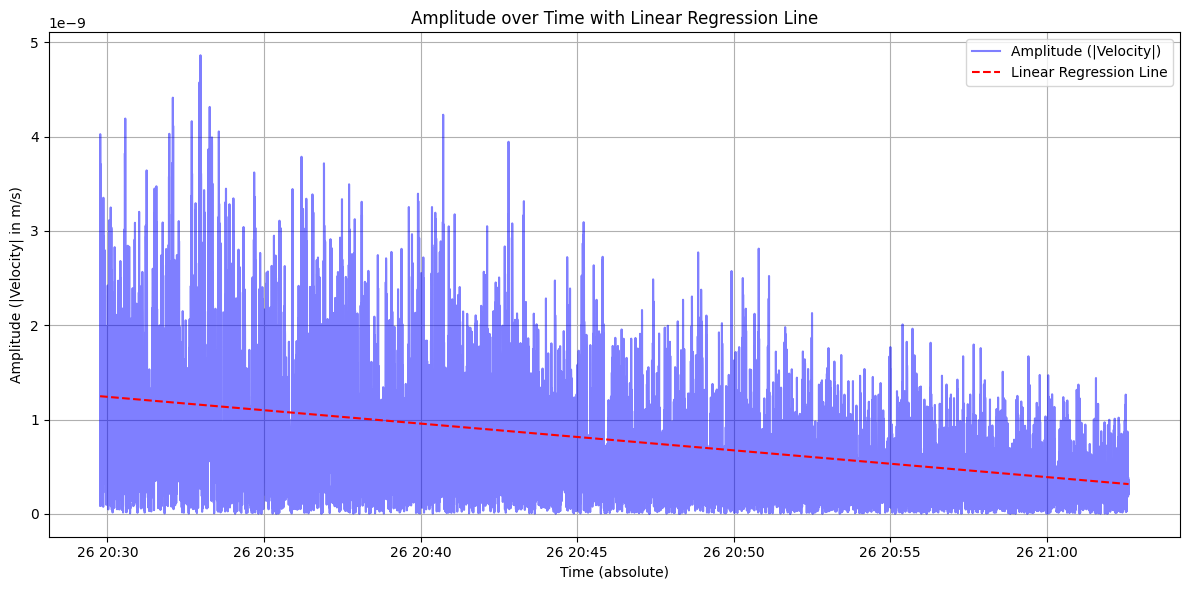

Slope: -4.72752165496717e-13
R² (correlation coefficient): 0.15762688718289197
Slice 2 - Correlation Coefficient (R²): 0.15762688718289197

false_positives: [25448.754716981133, 73785.2075471698]
true_positives: []
Analyzing slice 1 (from index 34425 to 49256)


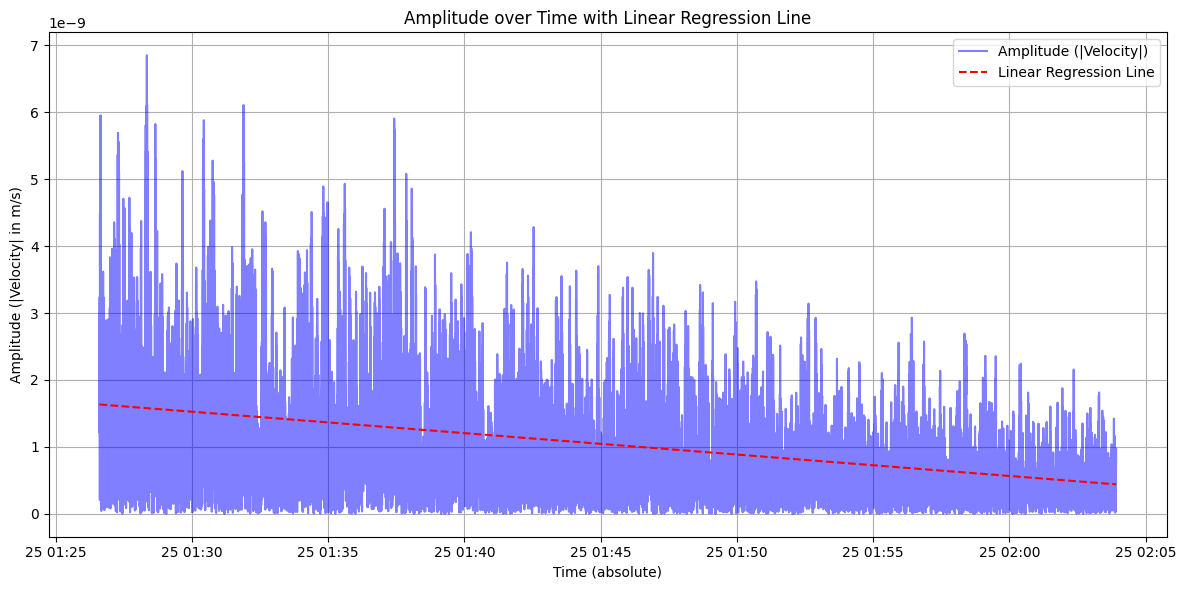

Slope: -5.33441240806971e-13
R² (correlation coefficient): 0.1472990777516333
Slice 1 - Correlation Coefficient (R²): 0.1472990777516333

false_positives: [5196.226415094339]
true_positives: []
false_positives: []
true_positives: []
Analyzing slice 1 (from index 299499 to 355125)


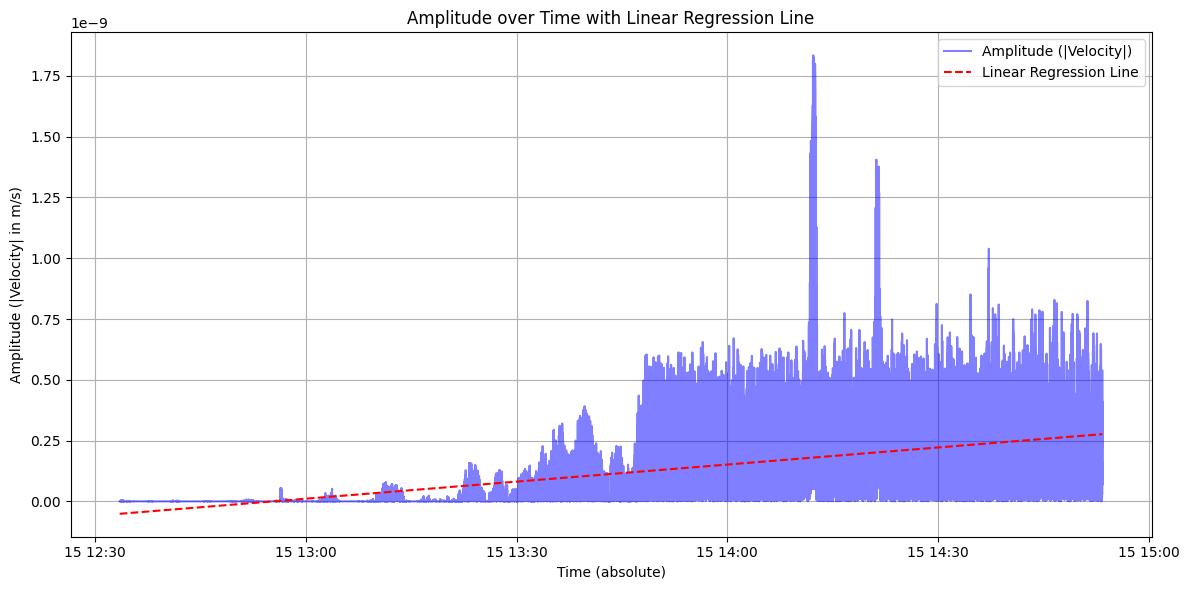

Slope: 3.902018193538804e-14
R² (correlation coefficient): 0.3056870995898363
Slice 1 - Correlation Coefficient (R²): 0.3056870995898363

Analyzing slice 2 (from index 455142 to 470054)


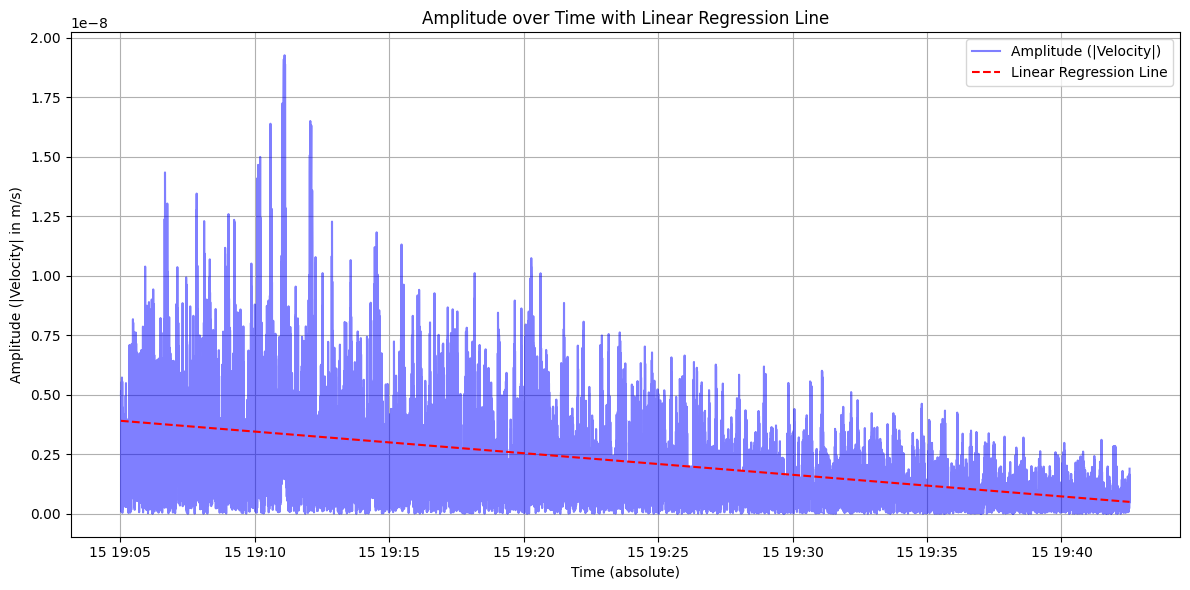

Slope: -1.512612160276341e-12
R² (correlation coefficient): 0.20873378534800158
Slice 2 - Correlation Coefficient (R²): 0.20873378534800158

false_positives: [68700.67924528301]
true_positives: [45207.3962264151]
Analyzing slice 1 (from index 479446 to 495508)


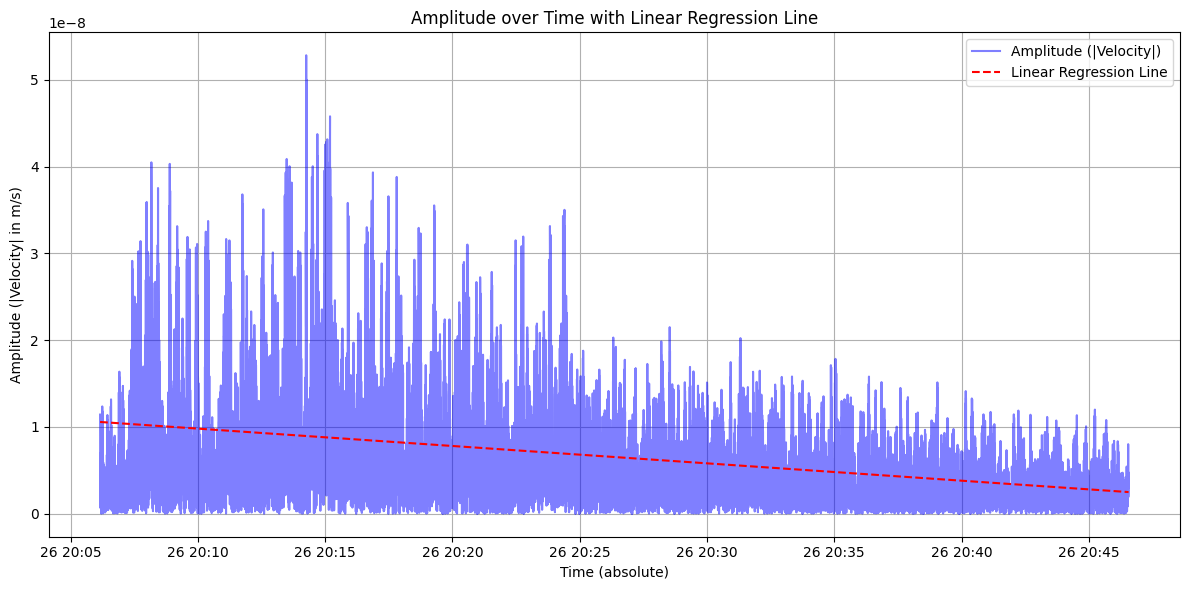

Slope: -3.3312372304079185e-12
R² (correlation coefficient): 0.13756065353292446
Slice 1 - Correlation Coefficient (R²): 0.13756065353292446

false_positives: [72369.2075471698]
true_positives: []
Analyzing slice 1 (from index 123893 to 140154)


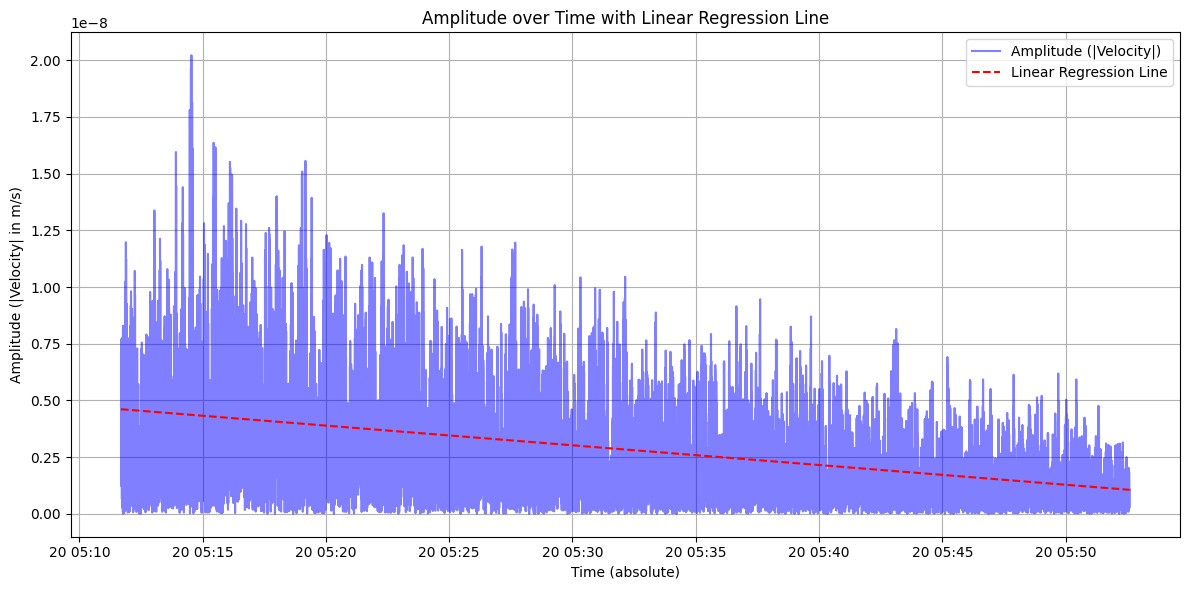

Slope: -1.4486015334244862e-12
R² (correlation coefficient): 0.17418669480949422
Slice 1 - Correlation Coefficient (R²): 0.17418669480949422

Analyzing slice 2 (from index 283184 to 295181)


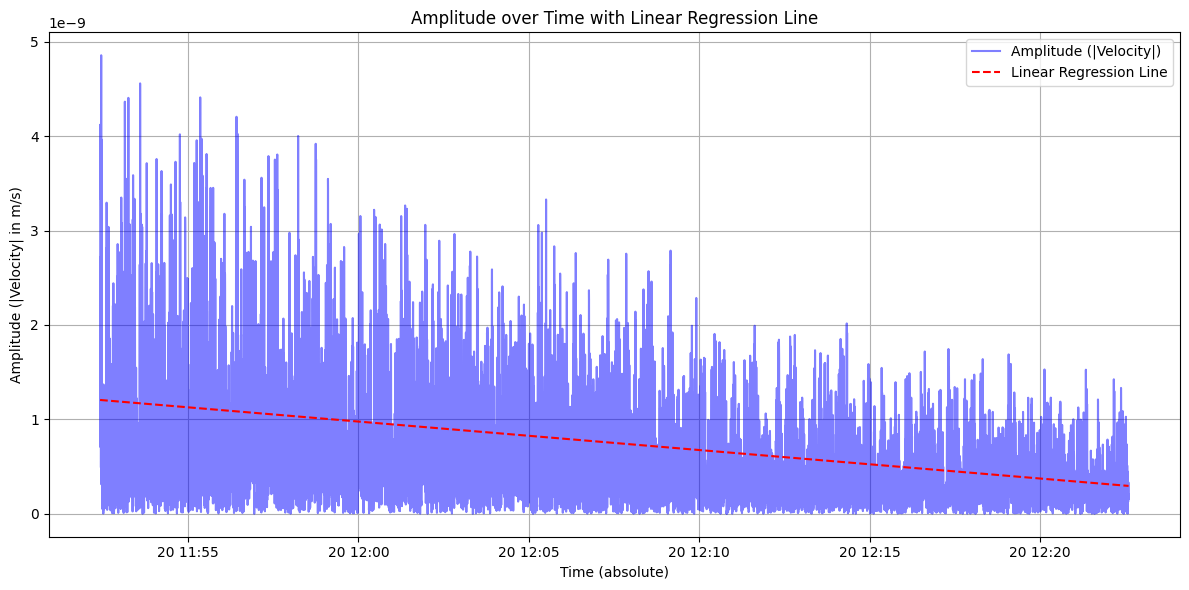

Slope: -5.028040804194657e-13
R² (correlation coefficient): 0.15806974607531665
Slice 2 - Correlation Coefficient (R²): 0.15806974607531665

false_positives: [18700.830188679247, 42744.75471698113]
true_positives: []
Analyzing slice 1 (from index 123893 to 140154)


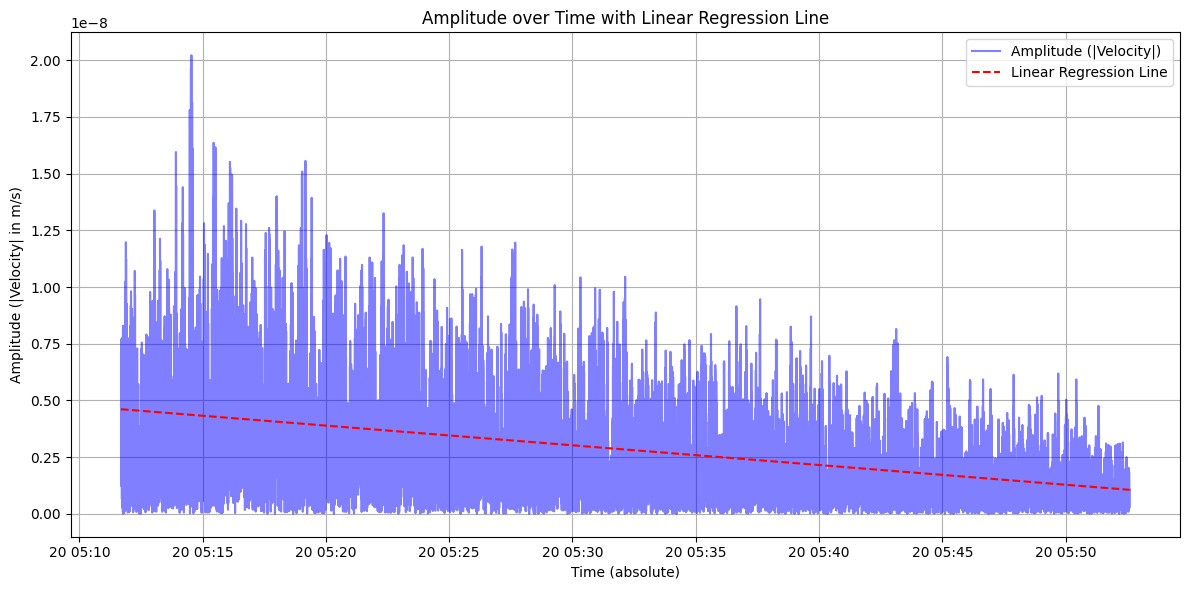

Slope: -1.4486015334244862e-12
R² (correlation coefficient): 0.17418669480949422
Slice 1 - Correlation Coefficient (R²): 0.17418669480949422

Analyzing slice 2 (from index 283184 to 295181)


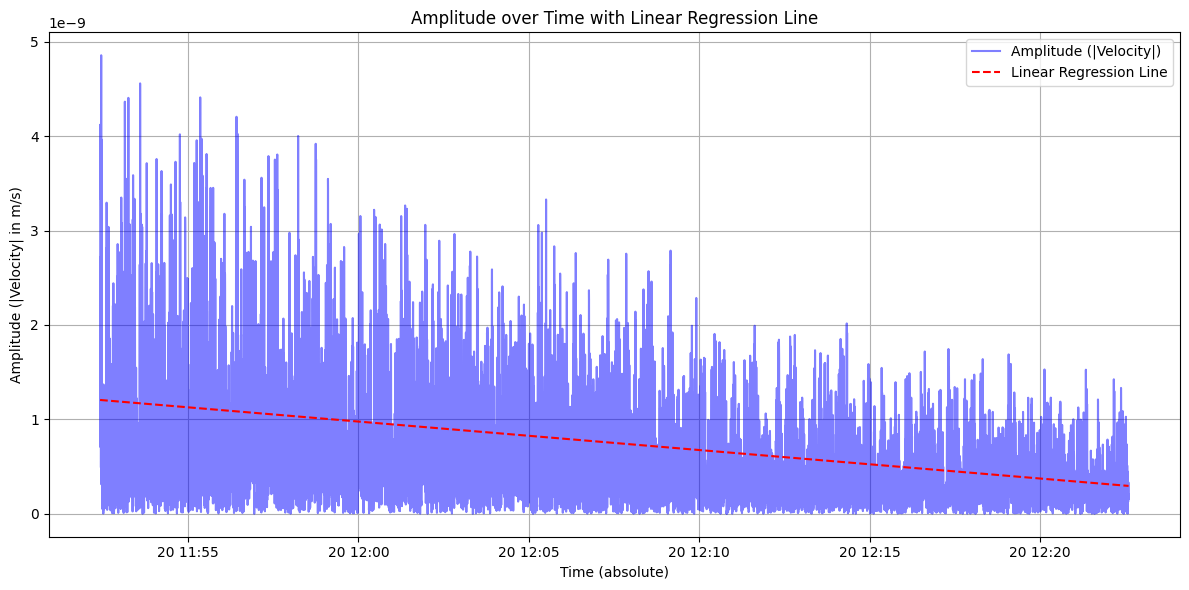

Slope: -5.028040804194657e-13
R² (correlation coefficient): 0.15806974607531665
Slice 2 - Correlation Coefficient (R²): 0.15806974607531665

false_positives: [18700.830188679247, 42744.75471698113]
true_positives: []
Analyzing slice 1 (from index 483243 to 494238)


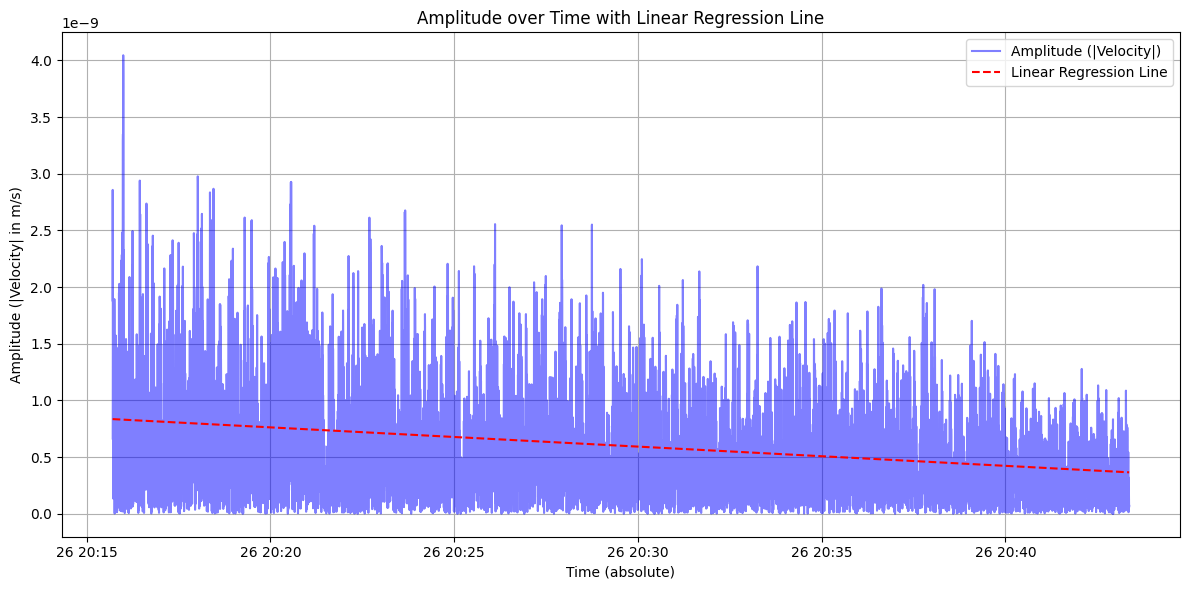

Slope: -2.829069251914196e-13
R² (correlation coefficient): 0.07951397064692567
Slice 1 - Correlation Coefficient (R²): 0.07951397064692567

false_positives: [72942.3396226415]
true_positives: []
Analyzing slice 1 (from index 412817 to 423174)


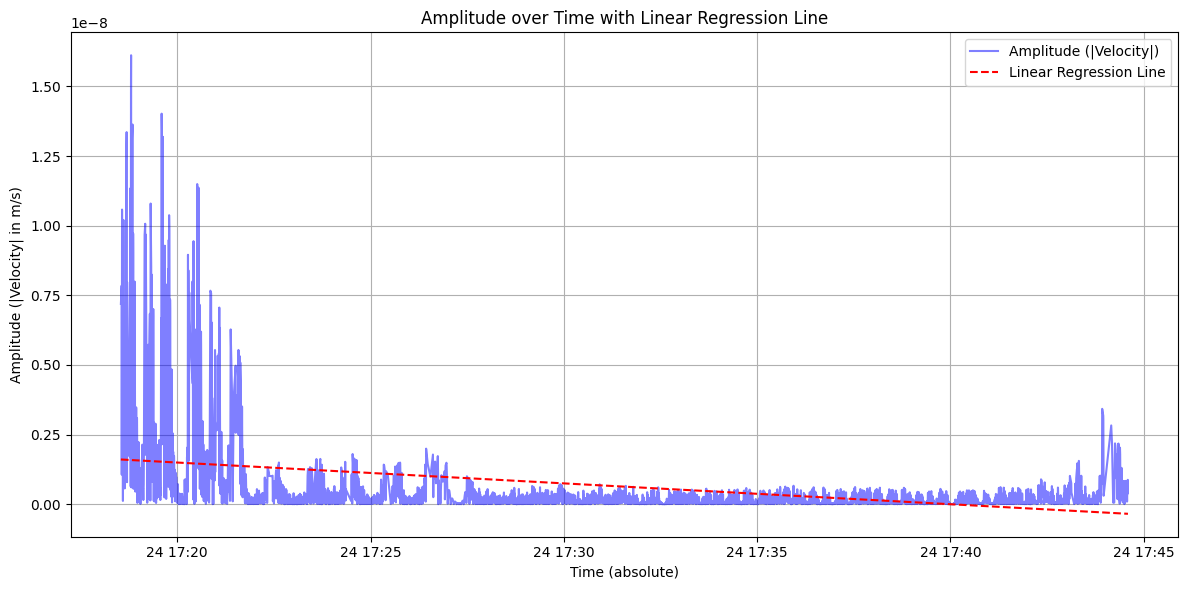

Slope: -1.247163985049999e-12
R² (correlation coefficient): 0.15271093555091741
Slice 1 - Correlation Coefficient (R²): 0.15271093555091741

Analyzing slice 2 (from index 478159 to 488194)


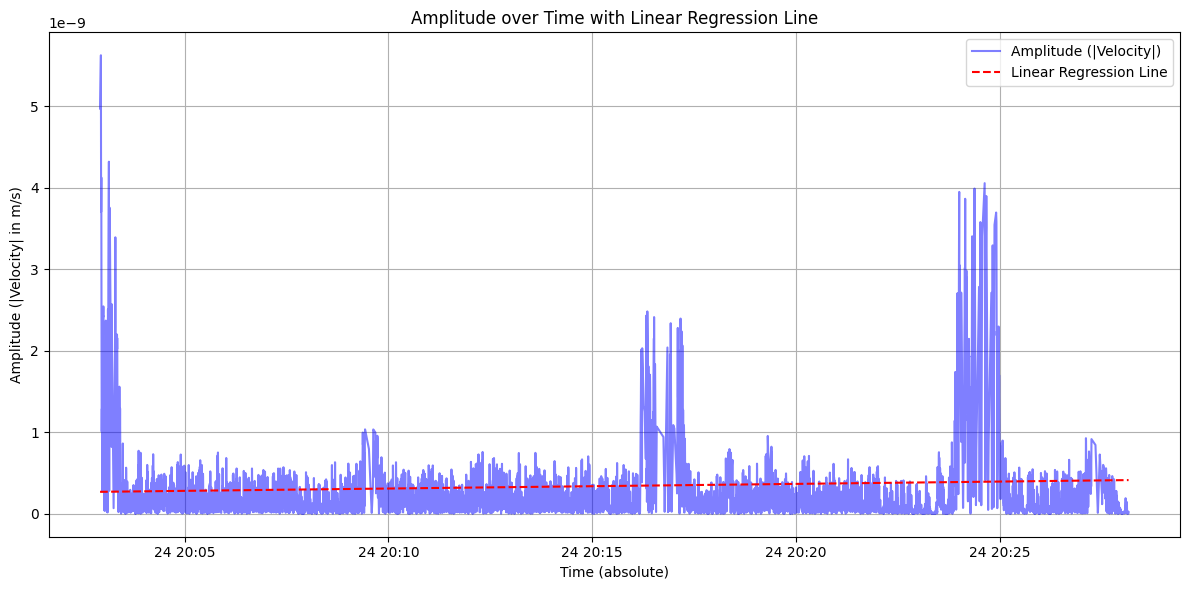

Slope: 9.49731460127343e-14
R² (correlation coefficient): 0.005834780203926582
Slice 2 - Correlation Coefficient (R²): 0.005834780203926582

false_positives: [62312.0, 72174.94339622642]
true_positives: []
Analyzing slice 1 (from index 112030 to 121888)


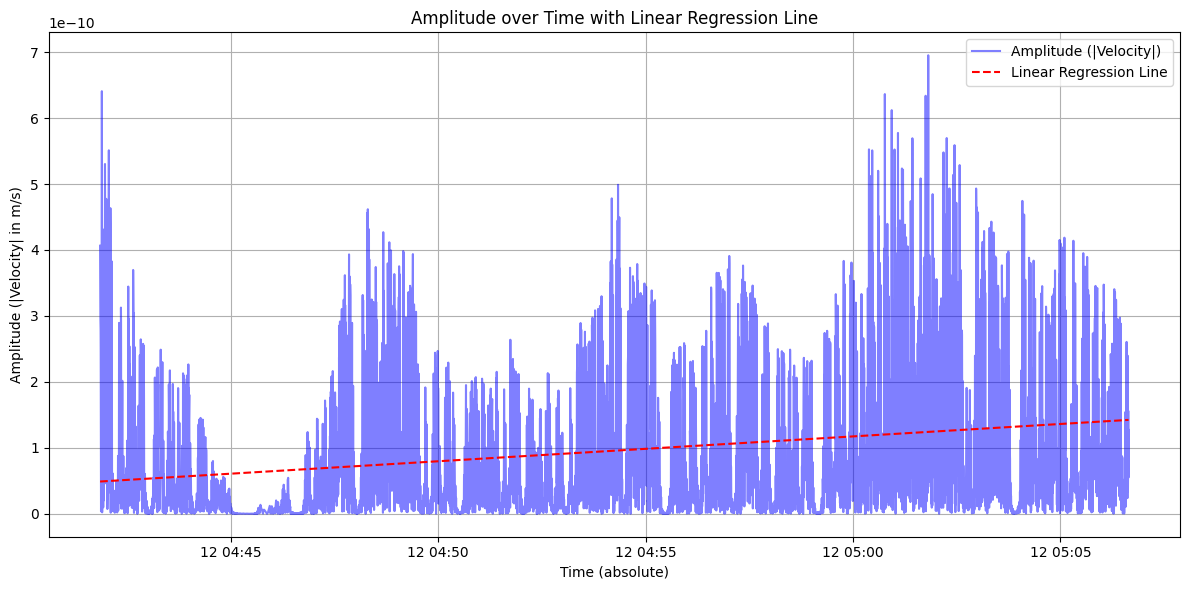

Slope: 6.280278034428612e-14
R² (correlation coefficient): 0.06688826279825444
Slice 1 - Correlation Coefficient (R²): 0.06688826279825444

Analyzing slice 2 (from index 312583 to 325958)


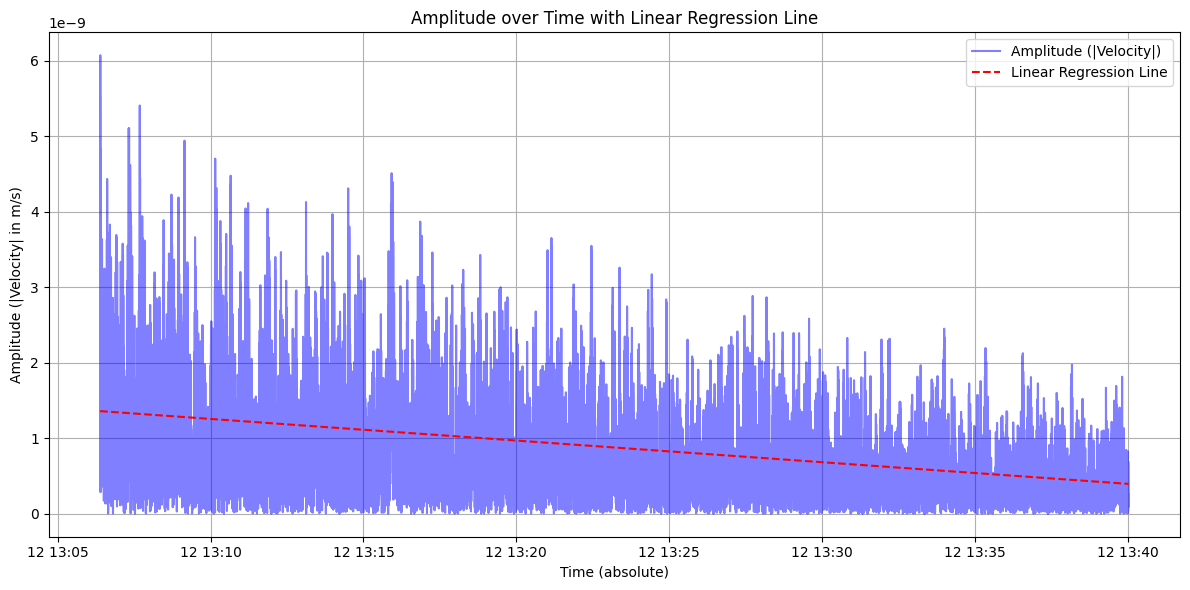

Slope: -4.773595490617665e-13
R² (correlation coefficient): 0.14145917231032812
Slice 2 - Correlation Coefficient (R²): 0.14145917231032812

Analyzing slice 3 (from index 519641 to 525687)


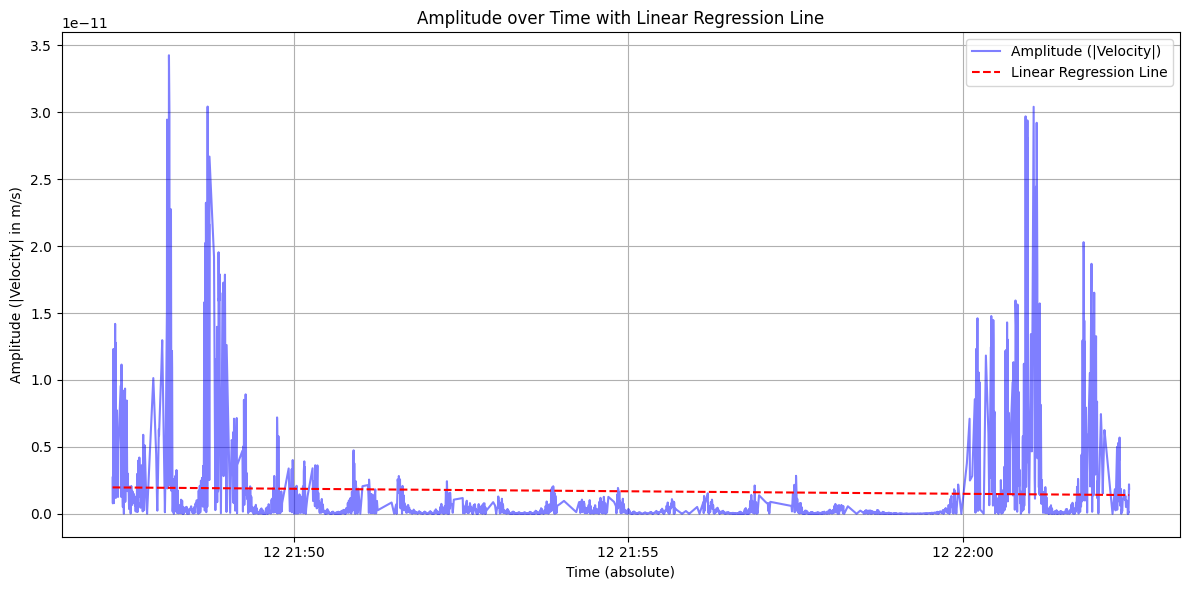

Slope: -6.254366915222924e-16
R² (correlation coefficient): 0.00208013696679199
Slice 3 - Correlation Coefficient (R²): 0.00208013696679199

false_positives: [16910.188679245282, 47182.33962264151, 78436.37735849057]
true_positives: []
Analyzing slice 1 (from index 177116 to 196031)


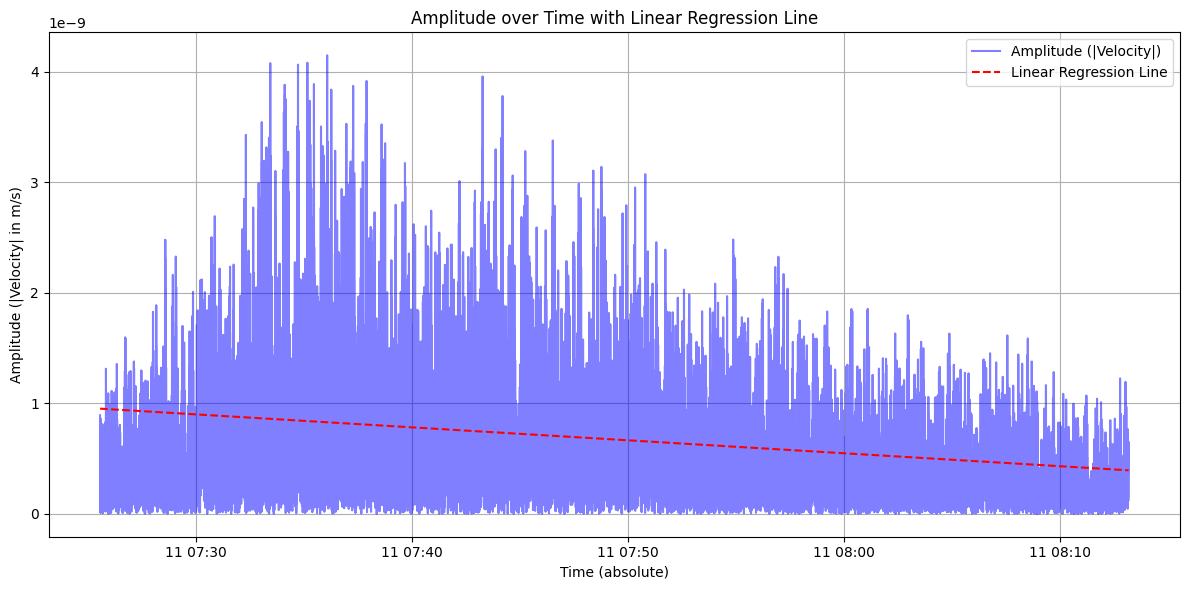

Slope: -1.9546713879751742e-13
R² (correlation coefficient): 0.07517730168227621
Slice 1 - Correlation Coefficient (R²): 0.07517730168227621

Analyzing slice 2 (from index 389520 to 399758)


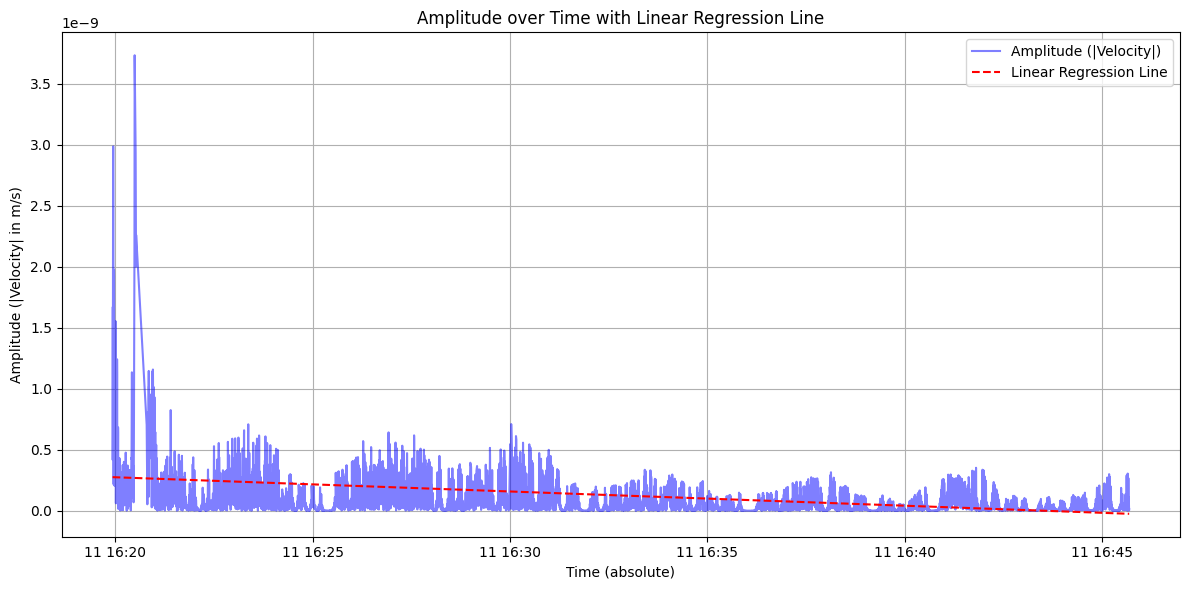

Slope: -1.9433644652208544e-13
R² (correlation coefficient): 0.12882397087475572
Slice 2 - Correlation Coefficient (R²): 0.12882397087475572

false_positives: [26734.490566037737, 58795.47169811321]
true_positives: []
Analyzing slice 1 (from index 495621 to 506949)


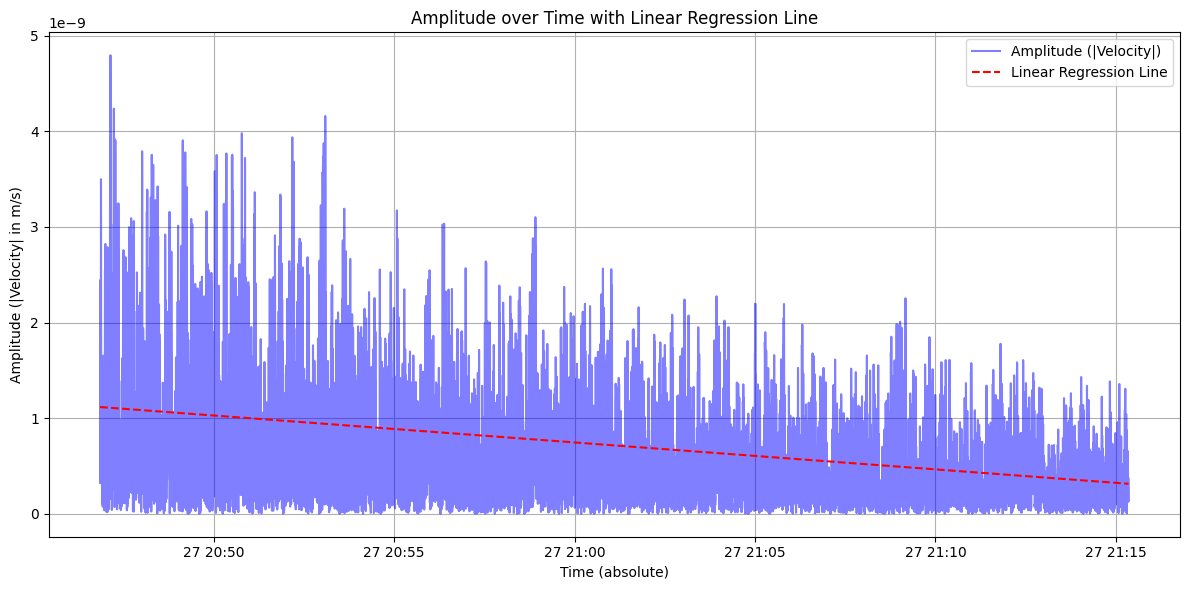

Slope: -4.694680328593728e-13
R² (correlation coefficient): 0.13702890188078531
Slice 1 - Correlation Coefficient (R²): 0.13702890188078531

false_positives: [74810.71698113208]
true_positives: []
Analyzing slice 1 (from index 370834 to 387212)


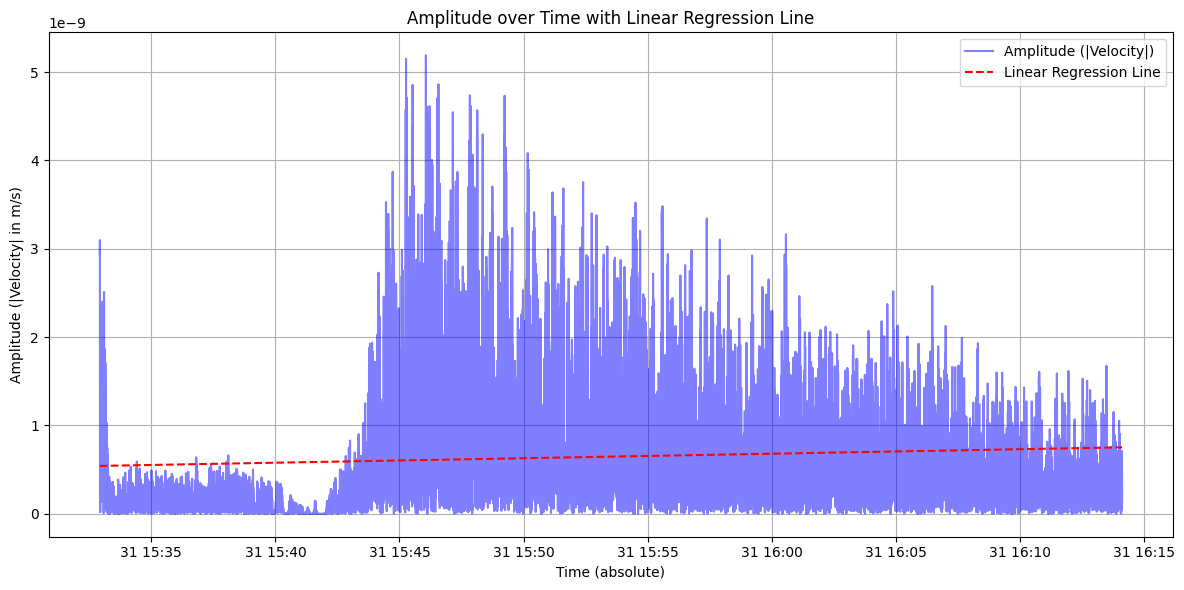

Slope: 8.493256456930249e-14
R² (correlation coefficient): 0.0076991167383616554
Slice 1 - Correlation Coefficient (R²): 0.0076991167383616554

false_positives: [55974.943396226416]
true_positives: []
Analyzing slice 1 (from index 303433 to 322510)


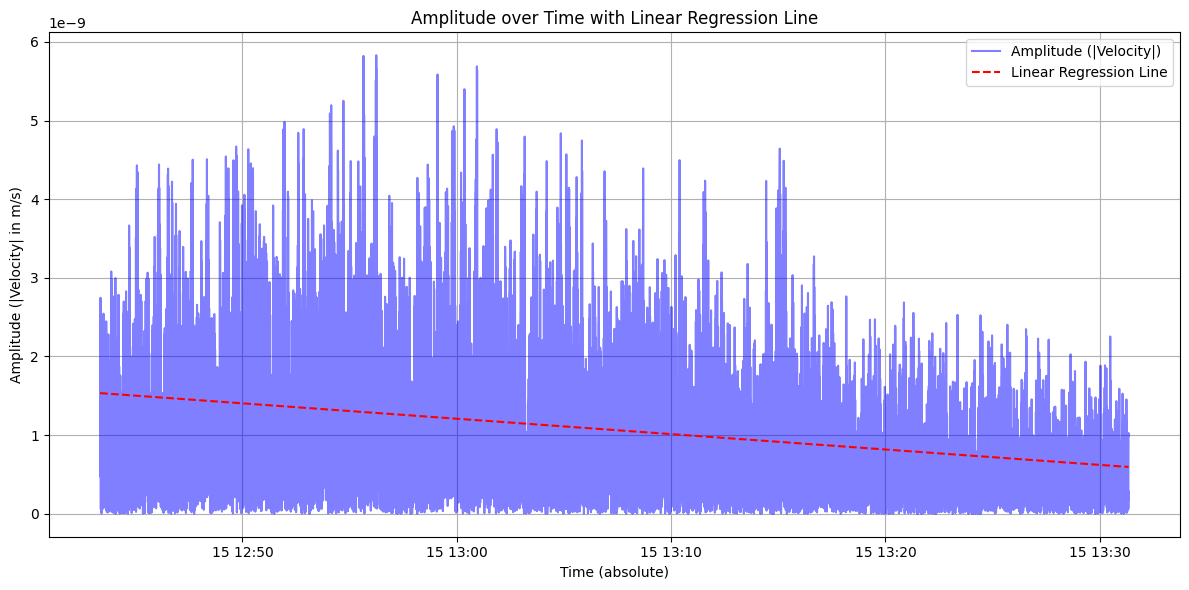

Slope: -3.2602223534447717e-13
R² (correlation coefficient): 0.09453222975788211
Slice 1 - Correlation Coefficient (R²): 0.09453222975788211

false_positives: [45801.20754716981]
true_positives: []
Analyzing slice 1 (from index 285534 to 295622)


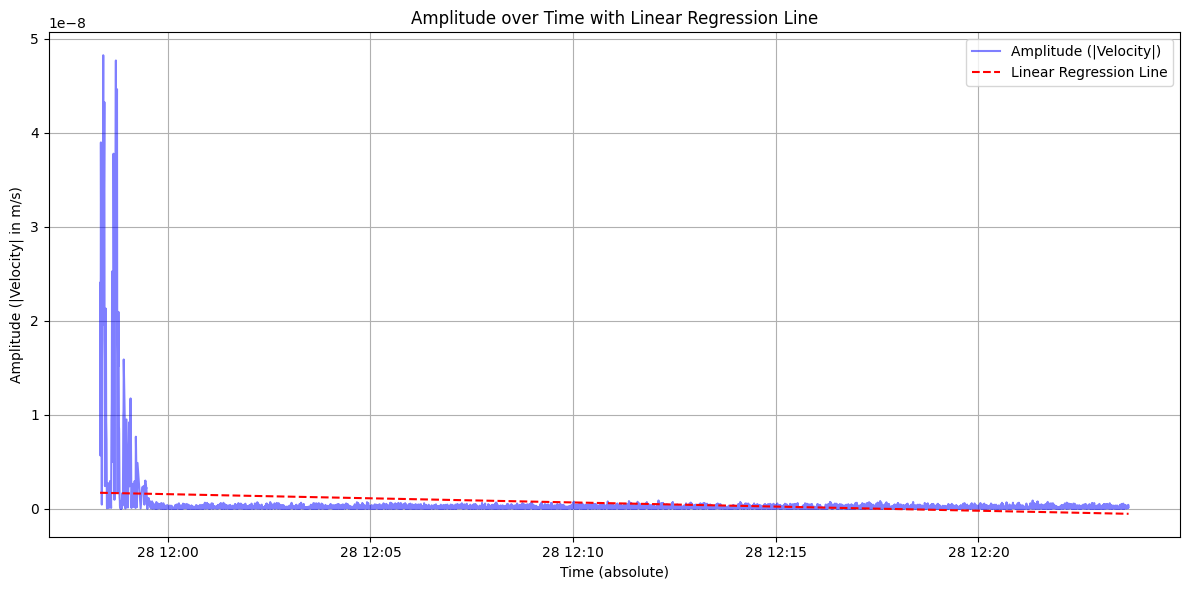

Slope: -1.4694593337083086e-12
R² (correlation coefficient): 0.0510228325624964
Slice 1 - Correlation Coefficient (R²): 0.0510228325624964

false_positives: [43099.47169811321]
true_positives: []
false_positives: []
true_positives: []
Analyzing slice 1 (from index 98649 to 108553)


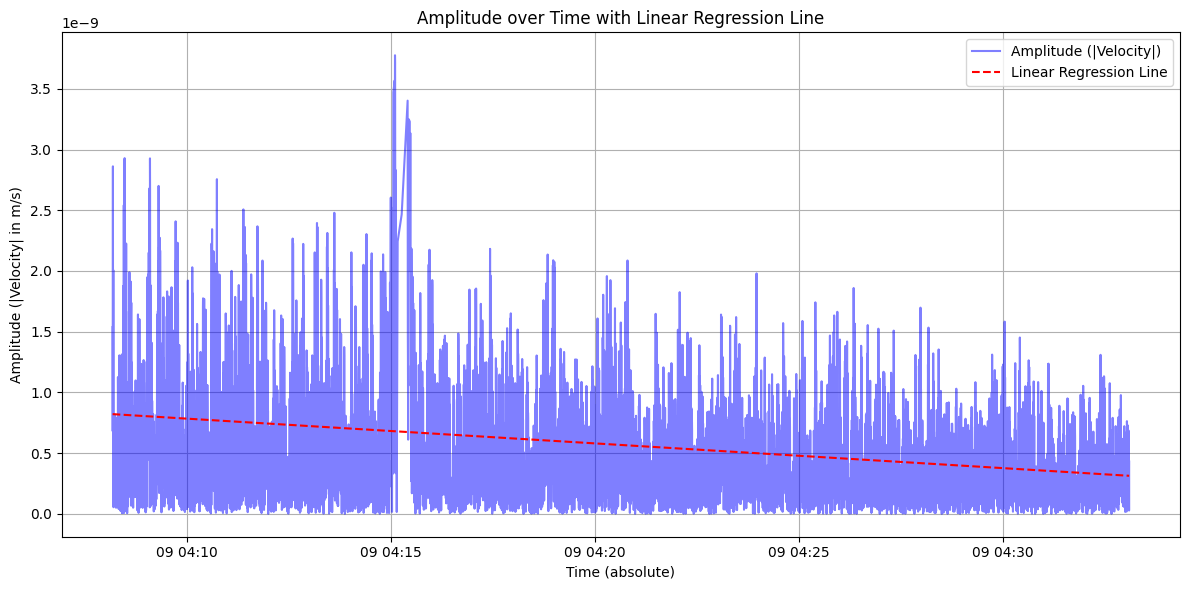

Slope: -3.3963437695049546e-13
R² (correlation coefficient): 0.08013212618265053
Slice 1 - Correlation Coefficient (R²): 0.08013212618265053

Analyzing slice 2 (from index 299650 to 309613)


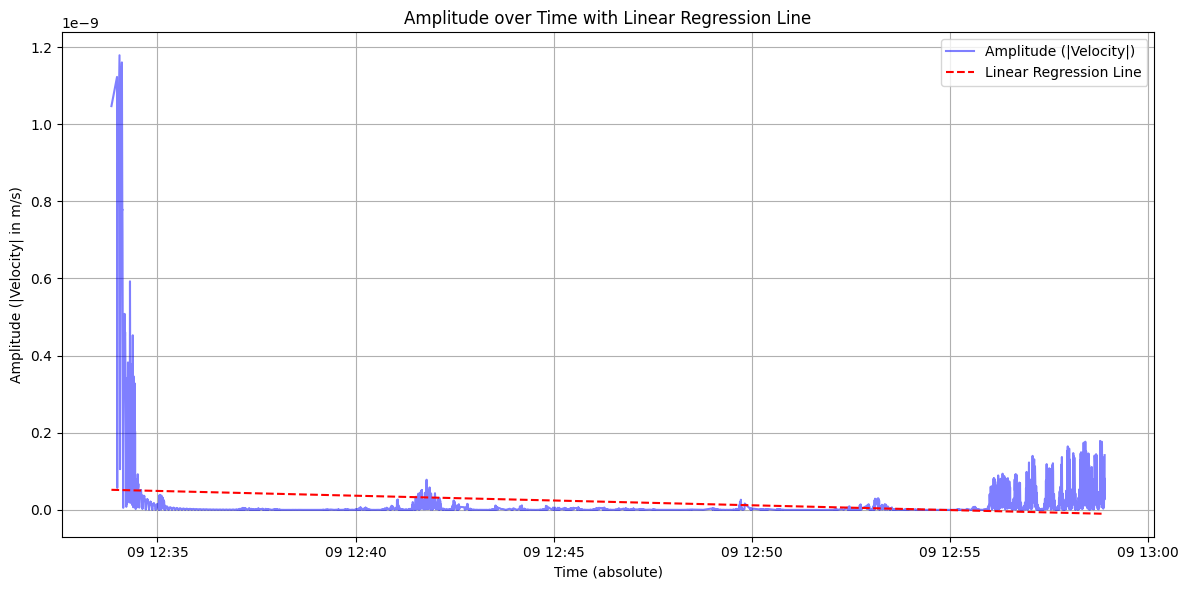

Slope: -4.134570168920854e-14
R² (correlation coefficient): 0.026387416526402863
Slice 2 - Correlation Coefficient (R²): 0.026387416526402863

Analyzing slice 3 (from index 343694 to 353669)


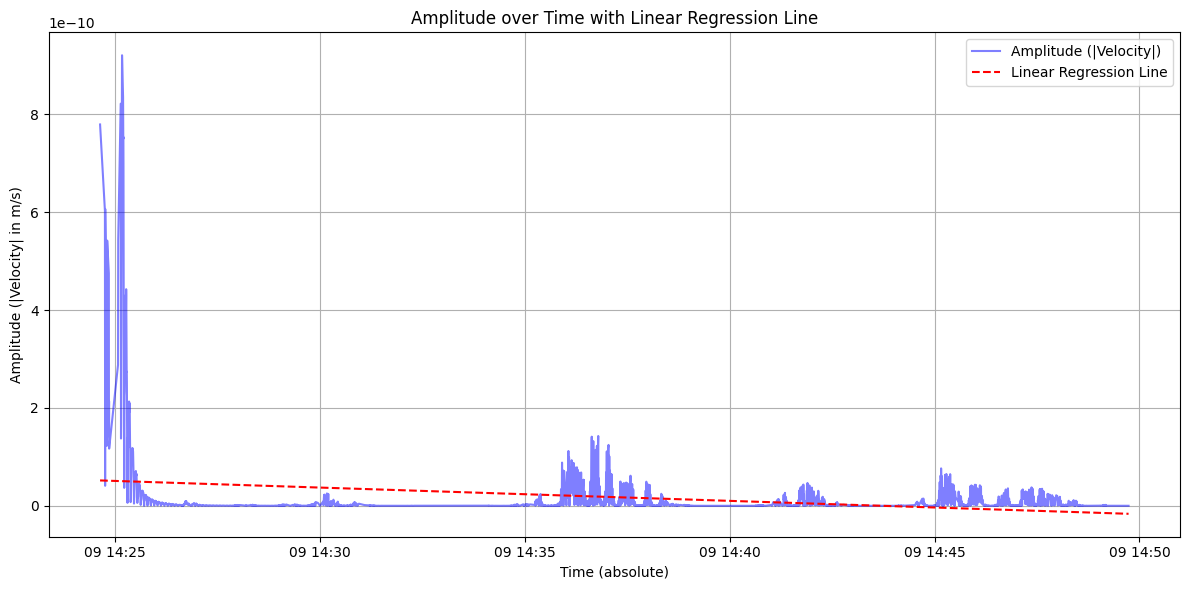

Slope: -4.529331776612519e-14
R² (correlation coefficient): 0.0592322886542791
Slice 3 - Correlation Coefficient (R²): 0.0592322886542791

Analyzing slice 4 (from index 457400 to 461528)


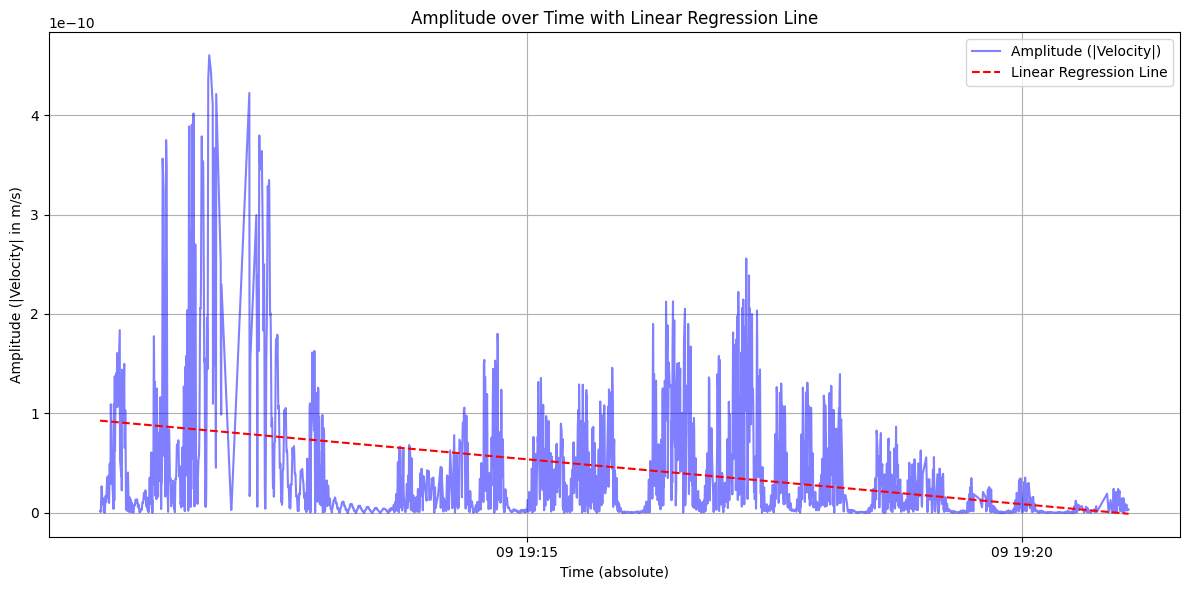

Slope: -1.5046231704446008e-13
R² (correlation coefficient): 0.13528842899054394
Slice 4 - Correlation Coefficient (R²): 0.13528842899054394

false_positives: [14890.415094339623, 45230.188679245286, 51878.33962264151, 69041.50943396226]
true_positives: []
false_positives: []
true_positives: []


FileNotFoundError: [Errno 2] No such file or directory: './space_apps_2024_seismic_detection/data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-04-13HR00_evid00029.csv'

In [37]:
for i in range(num_files):
    lunar_training_file = lunar_training_data_directory + lunar_cat['filename'][i] + '.csv'
    l_training_df = pd.read_csv(lunar_training_file)
    is_seismic(l_training_df)